# Analysis-ready, cloud-optimized data: writing zarr directories

Tutorial by Jonny Kingslake, Lamont-Doherty Earth Observatory

This tutorial will introduce analysis-ready, cloud-optimized (ARCO) data and describe one real-world example of restructuring some glaciological data and writing to an ARCO format, zarr. The data is from an ice-penetrating radar called the autonomous phase-sensitive radio-echo sounder (ApRES). 

A zarr store (or directory) is an ARCO data format that is well suited for storing high-dimensional, large-volume data in the cloud. A key characteristic of zarr stores is that they are 'chunked', meaning that the data is broken up into smaller pieces. This allows for parallel access to the data, which is very useful when you are trying to access subsets of large datasets and/or process large volumes of data in parallel. 

Depending on the configuration of the ApRES radar, and the survey conducted, it can produce high-dimensional, very large datasets, making these data suitable for storage with zarrs. 

Before we get to the ApRES data we should understand high-dimensional data and chunked data. 



## High-dimensional data: xarray
For our purposes, high-dimensional data is data that has more than 2 dimensions. For example, a typical satallite image is a two-dimensional dataset with two spatial dimensions, x and y (or latitude and longitude). If the satallite image has multiple bands it would be a three-dimensional dataset with two spatial dimensions and one band dimension, and if the satellite data consisted of multiple images quired at the same locatin  at different timethe dataset would be four-dimensional with two spatial dimensions, one band dimension, and one time dimension. 

[Xarray](http://xarray.pydata.org/en/stable/) is a python package designed to store and process high-dimensional data. It is built on top of [numpy](https://numpy.org/), which deals with arrays of data. Xarray adds very useful features including labelling of dimensions and broadcasting of operations across dimensions. Xarray also works very nicely with [dask](https://dask.org/), which is yet another python package, which allows you to 'chunk' your data and process it in parallel.

Before we get onto dask, let's take a look at xarray.

In [1]:
import xarray as xr

Let's load an example xarray dataset, supplied with the xarray package:

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This provides a convenient view the structure of the data. We see that there are three dimensions (`lat`, `lon` and `time`) and one variable (`air`). The variable `air` and the coorinates `lat`, `lon` and `time` are all stored as numpy arrays. You can access the numpy array underlying the variable in dataset `air` and verify its type as follows:

In [3]:
ds.air.values[0:2, 0:2, 0:2]

array([[[241.2    , 242.5    ],
        [243.79999, 244.5    ]],

       [[242.09999, 242.7    ],
        [243.59999, 244.09999]]], dtype=float32)

In [4]:
print(f"The variable air has type {type(ds.air.values)}")

The variable air has type <class 'numpy.ndarray'>


A great thing about xarray is that it allows to quickly look at, process, and plot this kind of data. For example, we can plot the mean of `air` over the `time` dimension as follows:

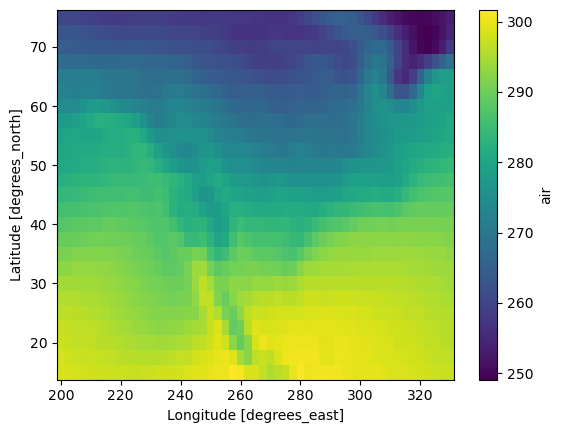

In [5]:
ds.air.mean(dim="time").plot();


Xarray has many other useful capabilites for slicing, coarsening, and plottnig data, some of which we will use below.

## Chunking: dask
The xarray above (`ds`) contained numpy arrays. To process or plot any part of a variable in `ds`, we need to load all of it into memory. This is fine if the data are small; the dataset above was only

In [6]:
print(f"{ds.nbytes/1e6} MB")

15.499672 MB


but this would be an issue if a variable was, say, 100GB. This would be too large to fit into memory on most computers and would complicate processing or plotting the data. This is where chunking and dask come in. Dask provides a new data structure, called a dask array, which is like a numpy array except that it is split up into smaller pieces called chunks. Let's load an example dask array (straight from the dask [documentation](https://examples.dask.org/array.html#Create-Random-array)): 

In [7]:
import dask.array as da
dask_array = da.random.random((1e6, 1e6), chunks=(5000, 5000))
dask_array

dask.array<random_sample, shape=(1000000, 1000000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

This created a dask array containing random values between -0.5 and 0.5. Calling `dask_array` displays a handy table containing information about this dask array. It's total size is 7TB! Clearly this is much too large to fit into memory. In fact, nothing has been loaded into memory except the structure of the dask array (i.e. the number and shape of the chunks) and the information needed to create it when we need it (i.e. the method `random`). 

The table also includes information on the chunks. There are 40,000 of them and each one is 190MB and 5000 by 5000 elements in size. Note that we chose this chunk size when we created the dask array. This is the key to dask arrays: we can choose the chunk size to suit our needs. You have to [make this choice carefully](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes#rough-rules-of-thumb) to optimize your processing. And worse, if your chunk sizes end up being non-uniform within a dimension, it causes issues when writing to zarr, as we will see later in our real-world example.

Two advantages of using dask arrays instead of an ordinary numpy arrays are 1) that we can view and plot a subset of the data without loading the whole thing into memory, and 2) we can very easily process the data in parallel. 

Let's first load a subset of the data into memory and plot it:

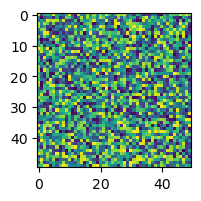

In [8]:
import matplotlib.pyplot as plt
dask_array_sub = dask_array[0:50, 0:50]
plt.figure(figsize=(2, 2))
plt.imshow(dask_array_sub);

In [9]:
print(f"This is a very small subset of the data: {dask_array_sub.nbytes/1e6} MB")

This is a very small subset of the data: 0.02 MB


Next, let's start up a dask cluster, then load and process a much larger subset of the data in parallel. The following cell starts and scales a cluster of cloud computers. Click on the "Launch dashboard in JupiterLab" button or clisk the url to open a dashboard that displays the progress of computations and other information. This slows down computations, but can be useful for seeing how your computations are progressing. To close down the cluster use 
```
client.shutdown()
```

In [10]:
from dask.distributed import Client
client = Client()
client.cluster.scale(10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jkingslake/proxy/8787/status,
Dashboard: /user/jkingslake/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 30.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45921,Workers: 4
Dashboard: /user/jkingslake/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 30.89 GiB
Comm: tcp://127.0.0.1:38199,Total threads: 1
Dashboard: /user/jkingslake/proxy/40385/status,Memory: 7.72 GiB
Nanny: tcp://127.0.0.1:34429,


In [11]:
dask_array_larger_subset = dask_array[:20000,:100000]
print(f"This subset is a little larger: {dask_array_larger_subset.nbytes/1e9} GB")

This subset is a little larger: 16.0 GB


In [12]:
%%time   
# with 10 workers
dask_array_larger_subset.mean().compute()

CPU times: user 1.84 s, sys: 237 ms, total: 2.08 s
Wall time: 13.3 s


0.5000123141607709

## Xarray + dask
Xarray and dask work very nicely together. The dataset we looked at above (`ds`) was made up of numpy arrays. We can instead tell xarray to load the data as dask arrays, therefore avoiding loading anything into memory until we need it. This is called lazily loading the data. We do this by defining the `chunks` argument when we load the data:

In [13]:
ds_dask = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 5, 'lon': 5, 'time': -1})
ds_dask

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 5, 5), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Now if we take a look at the variable `air` in `ds_dask` we can see that it is a dask array:

In [14]:
ds_dask.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

The convenient thing is that if an xarray contains dask arrays (instead of the usual numpy arrays), operations applied to the xarray will automatically be performed in parallel in the cluster. We will see this in action below using ApRES data. 

## ApRES data --> xarray --> zarr --> dask 

We are now ready to take a look at some real-world data. The data we will look at is from an ApRES radar. We will 
- discuss the structure of an ApRES survey,
- load some raw ApRES data,
- structure the data as an xarray, and 
- write this xarray to a zarr directory. 

This will make use of a library we have developed called [xApRES](https://github.com/ldeo-glaciology/XApRES). The main developers of this library have so far been Jonny Kingslake, George Lu, and Elizabeth Case. We very much welcome collaboration from anyone interested in efficient ways to process, store, and analyze ApRES data.

### Structure of an ApRES survey
The structure of an ApRES survey can get quite complex. The figure below depicts one possible structure of a so-called unattended survey (the details do not matter here, but ApRES can be operated in attended and unattended modes and the structure of data varies between the modes). 

![ApRES data structure](../img/ApRES_data_diagram.png)



**Chirps**

The radar emits individual 'chirps' which each generate a 40,001-element-long time series of data. The chirps are emitted at a rate of 1 per second. 

**Bursts**

The chirps are grouped into 'bursts', which each contain a user-definable number of chirps, which in the data below is 20 chirps. The system is setup to perform bursts at regular intervals. The data below has a burst interval of 15 minutes.

**Attenuator settings**

The ApRES has user-definable attenuator settings which are chosen during installation to ensure the signal is not too strong or too weak. Typically we choose more than one attenuator setting and cycle through them during each burst. So for example, if we have 3 attneuator settings, and 20 chirps per burst, per settting, the sequence of chirps would be 20 chirps using attenuator setting 1, followed by 20 chirps using attenuator setting 2, followed by 20 chirps using attenuator setting 3, followed by 20 chirps using attenuator setting 1, and so on.

This complexity leads to a four-dimensional dataset: 1) the time of each burst, 2) the chirp number within each burst, 3) the attenuator setting, and 4) the sample number in chirp. A typical workflow for processing datasets collected by such a survey is through nested for-loops and it is a major challenge keeping track of which chirp belongs where. 

This is where xarray can really help. Let's next load some raw ApRES data using some scripts fro a library we have been developing called xApRES.



### Load raw ApRES data
Raw ApRES data are stored in files with an extension `.dat`. First we install and import the xApRES library:

In [15]:
!pip install xapres -q
import xapres as xa

### The data
The ApRES data we will be using were collected in the ablation zone of the Greenland Ice Sheet by a team led by Meredith Nettles (Lamont-Doherty Earth Observatory, LDEO) and Laura Stevens (University of Oxford), including George Lu (LDEO), Stacy Larochelle (LDEO), Marianne Okal (Earthscope), Kristin Arnold (IRIS Alpine), and Josh Rines (Stanford University). The project was funded by the US National Science Foundation (project number: 2003464). Three ApRES units were positioned near several supraglacial lakes that periodically drain to the bed of the ice sheet. The units collected a burst every 15 minutes for up to 18 months. You can learn more about the science being done with these data (using the tools described here) in two oral presentation at AGU this week: [one](https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1321546) led by Stacy Larochelle and [one](https://agu.confex.com/agu/fm23/meetingapp.cgi/Paper/1316057) led by George Lu.

The map below shows the location of the three ApRES units over a ESA Sentinel-2 image from July 10, 2022 (created by George Lu).
We will be looking at data from A11.

![Map of ApRES locations in greenland](../img/ApRES_map.png)

Using xApRES we will create an instance of a `from_dats` object, then use two methods of these objects (`list_files` and `load_single`) to load 1 chirp from within 1 burst from within 1 `.dat` file.  

In [16]:
fd = xa.load.from_dats()
dat_file_list = fd.list_files(directory=f'gs://ldeo-glaciology/GL_apres_2022/A101', 
                remote_load = True)
fd.load_single(dat_file_list[30], remote_load = True, burst_number=0, chirp_num=0)

Let's take a look at the raw chirp data. It is 40001 elements long, as mentioned above, and we can plot it as follows:

In [17]:
len(fd.single_chirp.vdat)

40001

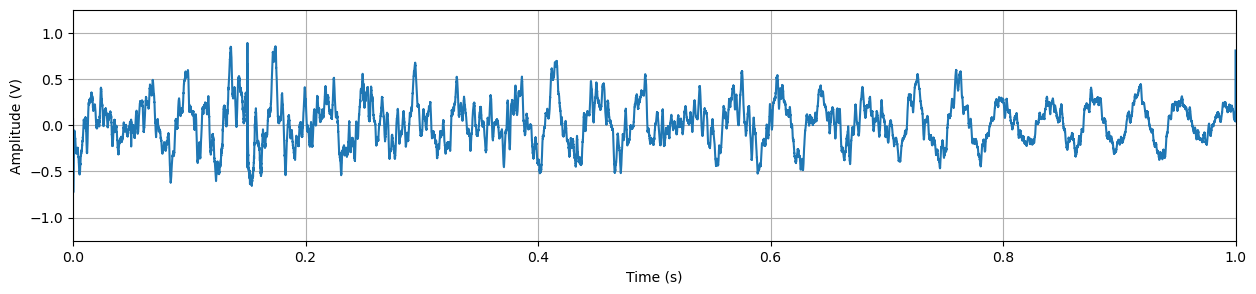

In [18]:
plt_1 = plt.figure(figsize=(15, 3))
plt.plot(fd.single_chirp.t, fd.single_chirp.vdat)
plt.axis([0,fd.single_chirp.t[-1],-1.25,1.25])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.grid("on")

We wont get into the details of processing ApRES data., but to obtain a representation of the reflection power as a function of depth we apply a fast fourier transform to the chirp. This is done in xApRES as follows:

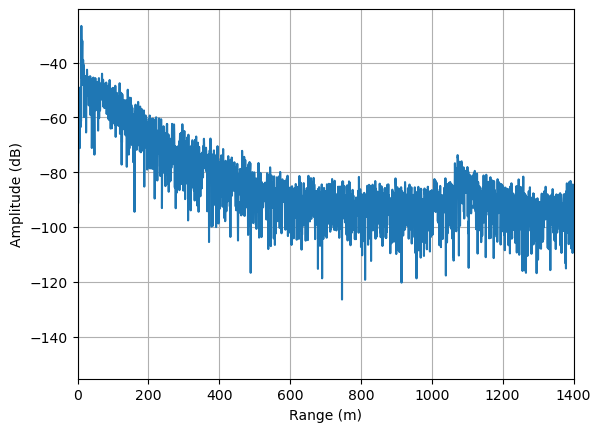

In [19]:
fd.single_chirp.FormProfile().PlotProfile(1400)

### Put these data into an xarray
The methods demonstrated above work well for loading and plotting single chirps, but as discussed above, when we have a large complex pRES dataset with multiple chirps and bursts and attenuator settings, we need a more convenient way of storing and accessing the data. When the data gets very large, we also need to be able to load and process subsets of the data without loading the whole thing into memory. Xarray can help.

xApRES has a collection of tools to load multiple `.dat` files and put them in to a useful structure within an xarray. 

Next we will use one of the tools to load all the data from one dat file:

In [20]:
ds = xa.load.generate_xarray(directory='gs://ldeo-glaciology/GL_apres_2022/A101', 
                             file_numbers_to_process=[30], 
                             remote_load=True)
ds

<xarray.Dataset>
Dimensions:          (time: 94, chirp_time: 40001, chirp_num: 20,
                      attenuator_setting_pair: 2, profile_range: 7134)
Coordinates:
  * time             (time) datetime64[ns] 2022-06-23T01:36:56 ... 2022-06-24...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.5e+03 1.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    filename         (time) <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 ... 86 87 88 89 90 91 92 93
    AFGain           (attenuator_setting_pair) int64 -4 -14
    attenuator       (attenuator_setting_pair) float64 5.0 5.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 68.71 68.71 68.71 ... 68.71 68.71 68.71
    longitude        (time) float64 -49.55 -49.55 -49.55 ... -49.55 -49.55
    battery_voltage  (time) float64 13.89 13.87 13.94 ... 13.85 13.84 13.84
    temperature_1    (time) float64 2.031 0.4609 508.9 ... 1.641 0.2656 510.9
    temperature_2    (time) float64 5.195 3.039 3.234 ... 4.805 2.25 0.6797

Here's a screenshot of the output of the cell above (in case this takes a long time to run):

![Screenshot of output of cell above](../img/xapres_xarray_screenshot.png)

The resulting xarray has five dimensions:
- `attenuator_setting_pair`: this is an index referring to the attenuator setting.
- `time`: the time of aquisistion of each burst. 
- `chirp_time`: the time since the beginning of each chirp of each sample within a chirp. As each chirp lasts 1 second, chirp_time varies from 0 to 1 second. There are 40001 samples by default, so the length of `chirp_time` is 40001. 
- `chirp_num`: this is number of chirps in each burst using each attenuator_setting_pair. So if the ApRES unit was configured to use 2 attenuator setting pairs and produce 20 chirps for each in each burst, the total number of chirps in a burst will be 2x20 = 40. 
- `profile_range`: the range to each sample in the profiles computed from each chirp using the fft. 

The two most important data variables are:
- `chirp`: the voltage measured during each chirp after the received signal is mixed with the simultaneously transmitted signal and low-pass filtered. This is an array of real values. 
- `profile`: the profiles resulting from an fft of the chirps. This is an array of complex values.
  



In [21]:
ds.nbytes/1e9

1.632827896

We can now use xarray to slicing, simple processing and plotting of the data, which would be time consuming and error prine using the raw data. For example, in one line we can select one of the two attenuator setting, compute decibels from the profile data, take the mean of the chirps in each burst, and plot the results:

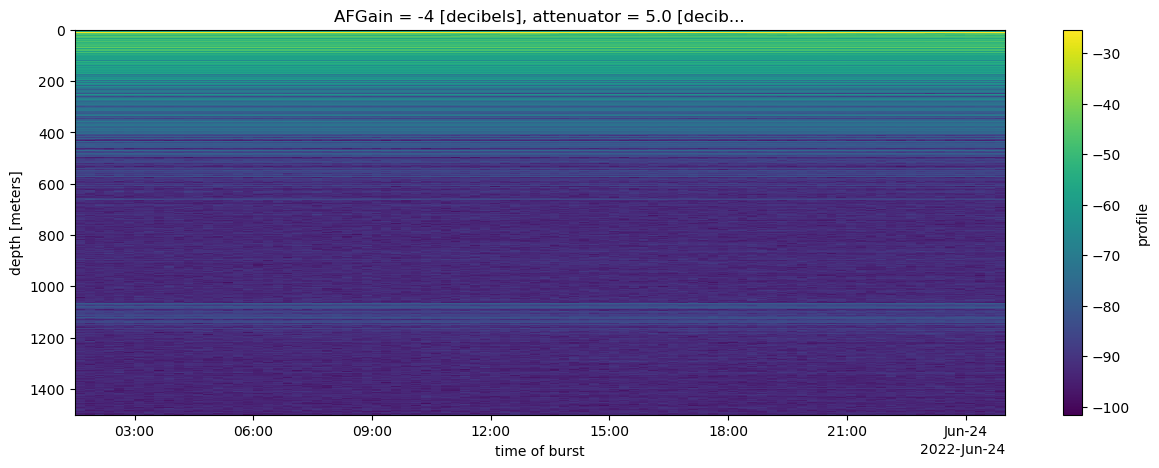

In [22]:
ds.profile.isel(attenuator_setting_pair = 0).dB().mean(dim=['chirp_num']).plot(x='time', yincrease=False, size=(5),aspect=3);

### Write to a zarr directory
Finally, we are on to the stage where we are going to write a zarr directory. The motivation for doing this the speed with which we will be able to access the data: it took 2 minutes to load and process the very small subset of the data above. If we want to do calculations using more of the dataset, it would be impractical to run `xa.load.generate_xarray` each time. 

For demonstration, we can save a subset of the dataset loaded above to a zarr store in the cryocloud s3 bucket as follows. Load two useful libraries for interacting with cloud storage:

In [23]:
import s3fs
import fsspec
import os

Next we find the url of the temporary directory assigned to us by cryocloud based on our github user names:

In [24]:
scratch = os.environ['SCRATCH_BUCKET']
scratch 

's3://nasa-cryo-scratch/jkingslake'

[s3fs](https://s3fs.readthedocs.io/en/latest/api.html#) provides tools to list and delete files and other operations:

In [25]:
s3 = s3fs.S3FileSystem()
s3.ls(scratch)

['nasa-cryo-scratch/jkingslake/temp1',
 'nasa-cryo-scratch/jkingslake/temp2',
 'nasa-cryo-scratch/jkingslake/temp3',
 'nasa-cryo-scratch/jkingslake/temp4']

Let's create a subest of the dataset `ds` we created above from `dat` files:

In [26]:
ds_small = ds.isel(time=slice(0,4))

Then we can write the dataset to a zarr store:

In [27]:
filename = f"{scratch}/temp5"
mapper = fsspec.get_mapper(filename)
ds_small.to_zarr(mapper, consolidated=False)

Finally, we reload the data and compare it to `ds` to ensure we accurately wrote it to and read it from the bucket: 

In [28]:
ds_reloaded = xr.open_dataset(filename, engine='zarr', consolidated=False, chunks={}) 
ds_reloaded

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 4, chirp_time: 40001,
                      chirp_num: 20, profile_range: 7134)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(4,), meta=np.ndarray>
    orientation      (time) <U7 dask.array<chunksize=(4,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.5e+03 1.5e+03
  * time             (time) datetime64[ns] 2022-06-23T01:36:56 ... 2022-06-23...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 10001, 10, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 3567, 10, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>

In [29]:
ds_reloaded.profile.identical(ds_small.profile)

True

If you want to delete the zarr store from the scratch bucket use:
```
s3.rm(filename, recursive=True)
```

This worked fine, but when we attempt to apply this to a whole season of data from this ApRES unit, we run encouner an issue. The step above involved loading the data in the `dat` file into memory; we dont have a way of lazily loading from `dat` files. The issue is that we cannot whole season of data into memory. To estimate the total size of these data, we can check the length of the list of `dat` files we created earlier ('dat_file_list') and multiply by the size of the xarray dataset we generated from one `dat` file above (`ds`):

In [30]:
print(f"{len(dat_file_list) * ds.nbytes/1e9} GB")

622.107428376 GB


Our way around this issue was to first save the xarray loaded from each `dat` file to a single zarr store, then load all the individual zarr stores lazily into a single xarray dataset and save this to one big zarr store.

#### Save each `dat` to a single zarr store
We used [this](https://github.com/ldeo-glaciology/xapres/blob/master/notebooks/to_zarr/to_individual_zarr.ipynb) notebook to save each `dat` file's data to an individual zarr store. The key cell is recreated below. This code will not work here, but we ran it on infrastructure very similar to cryocloud on a dask cluster. 

```
def xapres_to_zarr(site):  
    directory=f"gs://ldeo-glaciology/GL_apres_2022/{site}"
    
    fd = xa.load.from_dats(max_range=1400)
    dat_file_list = fd.list_files(directory=directory, 
                remote_load = True)

    with open('../../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
        token = json.load(token_file)
    
    num = 0
    for file in tqdm_slack(dat_file_list, token=slack_token, channel='python-timer'): 
        
        fd = xa.load.from_dats(max_range=1400)
        fd.load_all(directory, 
                remote_load = True,
                file_names_to_process=[file])
        
        filename = f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_2/dat_{num}' 
        mapper = fsspec.get_mapper(filename, mode='w', token=token)

        ds = fd.data
        #ds = fd.data.chunk({'time':1,'attenuator_setting_pair':-1, 'chirp_num':-1, 'profile_range': -1, 'chirp_time':-1  })
        
        ds.attrs = []
        ds.to_zarr(mapper, consolidated=False)
        
        del xa
        del ds
        num+=1
        
```

#### Lazily load every all zarr store and write to one big zarr 
The next step is to load each zarr file lazily into a single xarray dataset and save this to a single zarr store. We used [this](https://github.com/ldeo-glaciology/xapres/blob/master/notebooks/to_zarr/write_big_zarrs.ipynb) notebook to do this. The key code is as follows.

```
def zarrs_to_onezarr(site):
    ds = xr.open_mfdataset(f'gs://ldeo-glaciology/apres/greenland/2022/{site}/individual_zarrs_2/dat_*',
                               chunks = {}, 
                               engine = 'zarr', 
                               consolidated = False, 
                               parallel = True)
    ds['attenuator'] = ds.attenuator[500]
    ds['AFGain'] = ds.AFGain[500]
        
    for var in ds:
        del ds[var].encoding['chunks']

    profile_stacked = ds.profile.mean(dim='chirp_num')
    ds_stacked = ds.assign({'profile_stacked':profile_stacked})
    ds_stacked_rechunked = ds_stacked.chunk({'time':20})
    
    #encoding = {i: {"dtype": "float64"} for i in ds_stacked_rechunked.data_vars}
    encoding = {
        'time': {
            'units': 'seconds since 1970-01-01'}}

    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}' 
    mapper = fsspec.get_mapper(filename, mode='w', token=token) 
    with performance_report(f'ds_stacked_rechunked_{site}.html'):
        ds_stacked_rechunked.to_zarr(mapper, consolidated=True, safe_chunks=False, encoding=encoding)
```


The method described above works in principle, but in practice we found that the process continued for a very long time, gradually filling the notebook memory, until the kernal finally died. 

The issue was chunking!

Let's take a look at the chunk sizes of the zarr stores we created above:

In [31]:
datasets = []

names = [f'gs://ldeo-glaciology/apres/greenland/2022/A103/individual_zarrs_2/dat_{num}' for num in range(0,127)]

for name in names[0:7]:
    ds = xr.open_dataset(name,
                         chunks = {}, 
                         engine = 'zarr', 
                         consolidated = False)
    dim_to_print = 'time'
    dim_num = ds.profile.get_axis_num(dim_to_print)
    print(f"Chunk sizes along the {dim_to_print} dimension = {ds.profile.chunks[dim_num]}")

Chunk sizes along the time dimension = (1,)
Chunk sizes along the time dimension = (3, 3, 3, 3)
Chunk sizes along the time dimension = (1, 1, 1)
Chunk sizes along the time dimension = (10, 10, 10, 10)
Chunk sizes along the time dimension = (1,)
Chunk sizes along the time dimension = (12, 12, 12, 12, 12, 12, 12, 10)
Chunk sizes along the time dimension = (12, 12, 12, 12, 12, 12, 12, 10)


The `.chunks` attribute contains a list (actually a tuple) with each element corresponding to a different dimension and containing a list of the chunk sizes. In the cell above we extracted the list corresponding to the time dimension. 

The chunk sizes vary within each xarray and between xarrays. To see the implications of this, we will lazily load a few of the individual zarr stores into a single xarray dataset, then take a look at the resulting chunk sizes:

In [32]:
ds_some_zarrs = xr.open_mfdataset(names[0:7],
                           chunks = {}, 
                           engine = 'zarr', 
                           consolidated = False, 
                           parallel = True)
ds_some_zarrs

<xarray.Dataset>
Dimensions:          (time: 245, attenuator_setting_pair: 2, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (time, attenuator_setting_pair) int64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    attenuator       (time, attenuator_setting_pair) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-02-17T16:37:49 ... 2022-05-28...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(1, 5001, 5, 1), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(1, 1665, 5, 1), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

Text(0, 0.5, 'Chunk size')

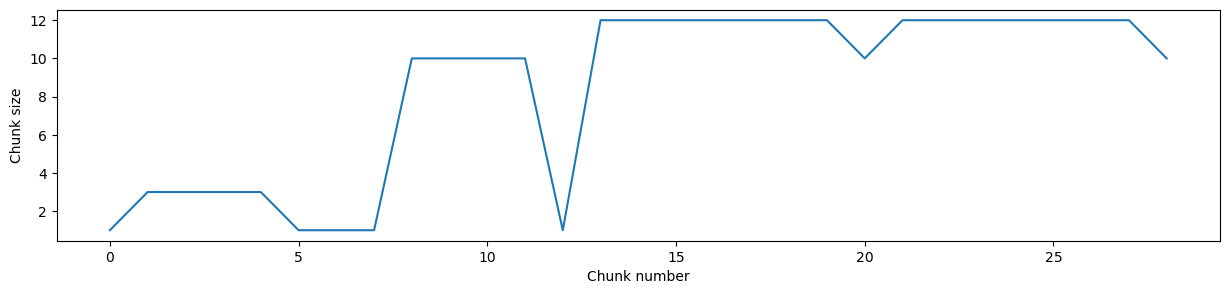

In [33]:
plt.figure(figsize=(15, 3))
plt.plot(ds_some_zarrs.profile.chunks[dim_num]);
plt.xlabel("Chunk number")
plt.ylabel("Chunk size")

This presents a problem because [zarr stores require uniform chunk sizes](https://zarr.readthedocs.io/en/stable/spec/v2.html#chunks) within each dimension (except for the last chunk). When it comes to writing the whole lazily loaded xarray, this means that you must first 'rechunk' the data. This is a very costly operation, which is why this stage of the procedure was failing. In this toy scenario illustrated in the figure below, one chunk in the original dataset is potentially accessed by multiple workers simultaneously working on writing multiple chunks. At the same time, each new chunk in the rechunked dataset must be built using data from multiple chunks in the original dataset. In large datasets, this gets very computationally intensive. 

![chunking](../img/chunking.png)

The solution was to rechunk the data loaded from each `dat` file prior to the frst write to zarr so that the length of the chunks in the time dimension is 1, using the following line:
```
ds = fd.data.chunk({'time':1, 'attenuator_setting_pair':-1, 'chirp_num':-1, 'profile_range': -1, 'chirp_time':-1  })
```

Finally, when each individual zarr store was lazily loaded, we rechunked to 20 in the time dimension before concatenating, so that the resulting xarray had reasonable chunk sizes. 

The full procedure is summarized in the following diagram: 


![apres_worksflow](../img/apres_workflow.png)

### Read the resulting zarr and plot
The result is a zarr store containing a whole season of data from ApRES site A103:

In [34]:
ds = xa.load.load_zarr("A103")
del ds['filename']
ds

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11763,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-02-17T16:37:49 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

To demonstrate the utility of having the data in this format we can do something simple that requires a lot of data, like taking the mean of the chirp voltages. The chirp data is ~150GB,

In [35]:
ds.chirp.nbytes/1e9

150.57016416

so let's time how long it takes with 10 workers to compute the mean of those data.

In [36]:
%%time 
# with 10 workers
ds.chirp.mean().compute()

CPU times: user 29.7 s, sys: 6.15 s, total: 35.8 s
Wall time: 3min 49s


<xarray.DataArray 'chirp' ()>
array(0.02804514)

It took around 4 minutes to get through 150 GB. 

Finally, let's make a depth-time plot.
This requires:
- subsetting with `.isel(attenuator_setting_pair = 0, time = slice(200,11763))`
- computing decibels from the complex profiles with `.db`, which `xa.load.load_zarr` adds to the xarray 
- compute the mean of the profiles from each burst with `.mean(dim=['chirp_num'])`
- coarsen in time, because plotting the full resolution would require a lot of data to be in the machine running the notebook with `.coarsen(time=10, boundary='trim').mean()` and
- plot a color map with `.plot(x='time', yincrease=False, size=(5),aspect=3)`:



CPU times: user 1min 5s, sys: 8.86 s, total: 1min 13s
Wall time: 5min 35s


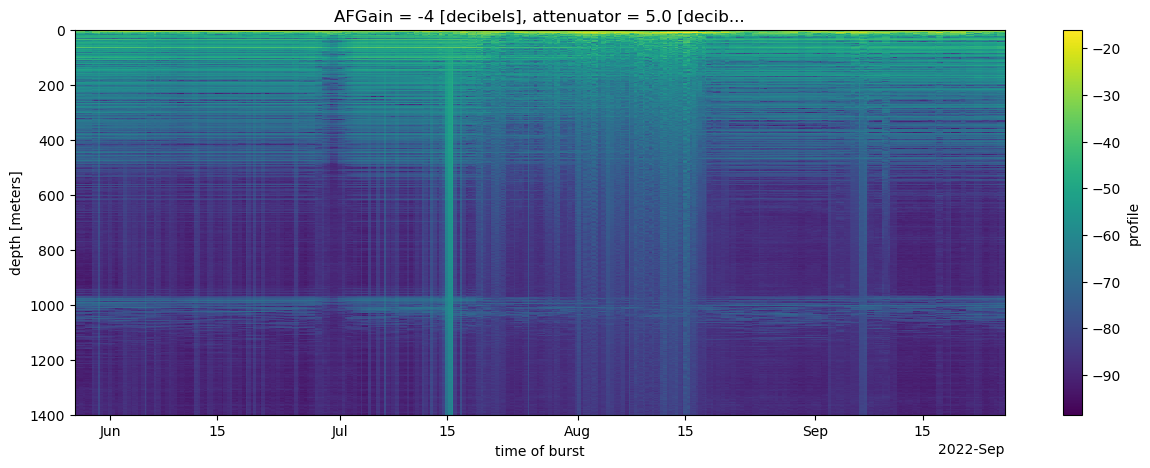

In [37]:
%%time
ds.profile.isel(attenuator_setting_pair = 0, time = slice(200,11763)).dB().mean(dim=['chirp_num']).coarsen(time=10, boundary='trim').mean().plot(x='time', yincrease=False, size=(5),aspect=3);

## Take home messages
- xarray is a great tool for storing and processing high-dimensional data
- dask works seamlessly with xarray and with dask clusters supplied by cryocloud, and allows rapid parallel processing, exploratory analysis, and plotting of large datasets. 

When attempting to write your own data to a zarr store:
- have a very clear idea of the data's structure,
- carefully consider the chunking you want your final dataset to have, 
- you may need to design a workflow that avoids loading the whole dataset into memory at one time, and
- your workflow will need to result in uniform chink sizes within each dimension. 

## Further information
- Elliana Abrahams' [tutorial](https://book.cryointhecloud.com/tutorials/dask_for_geoscientists.html) on Dask for Geoscientists provides more detail on dask
- [This page](https://ldeo-glaciology.github.io/glaciology-intro-book/sections/radar/apres/chirps.html) in the Glaciology jupytebook provides an intrduction to how the ApRES radar works. 
- The [xapres repo](https://github.com/ldeo-glaciology/xapres) and this [notebook](https://github.com/ldeo-glaciology/xapres/blob/master/notebooks/guides/usingXApRES.ipynb) contain more information about the library of functions used to put ApRES code into xarray
The [pangeo gallery](https://gallery.pangeo.io/repos/ldeo-glaciology/pangeo-glaciology-examples/) has a few examples that use glaciological data